# 1 - Introdução 
A rede de academias Model Fitness está em um processo de modernização de sua estratégia de CRM, buscando substituir abordagens reativas por uma cultura baseada em dados. O principal desafio enfrentado é a rotatividade de clientes (churn), um fenômeno comum no setor fitness, onde a desistência muitas vezes ocorre de forma silenciosa ("saída de fininho"), sem o cancelamento formal do contrato.

Para o modelo de negócio da Model Fitness, definiu-se que um cliente entrou em rotatividade quando deixa de frequentar a unidade por um mês completo. Com a digitalização dos perfis dos clientes, o foco agora é transformar esses dados em inteligência para antecipar a saída do usuário e fortalecer o engajamento.

### Objetivos do Projeto
O propósito central desta análise é desenvolver uma estratégia de retenção fundamentada em evidências. Para isso, o projeto se divide nos seguintes objetivos específicos:

- Predição de Rotatividade: Desenvolver um modelo capaz de calcular a probabilidade de churn para o mês seguinte de cada cliente.
- Perfilamento de Usuários: Identificar e descrever os perfis (retratos) dos usuários típicos, agrupando-os por características comportamentais e demográficas.
- Identificação de Fatores Críticos: Analisar quais variáveis (como frequência, tipo de contrato ou idade) têm maior impacto na decisão do cliente de sair ou permanecer.
- Plano de Ação: Formular recomendações práticas, sugerindo medidas para reduzir a rotatividade e identificar grupos-alvo para campanhas de marketing e melhorias no serviço.

**Descrição dos dados** 
- ``Churn`` — a rotatividade do mês em questão  
Campos de dados atuais:  
Dados do mês anterior
- ``gender``
- ``Near_Location`` — se o cliente morar ou trabalhar na vizinhança onde a academia está localizada
- ``Partner`` — se o usuário for um funcionário de uma companhia parceira (a academia tem empresas parceiras cujos funcionários conseguem descontos; nesses casos, a academia armazena informações sobre clientes de são funcionários)
- ``Promo_friends`` — se o cliente originalmente se inscreveu através de uma oferta "traga um amigo" eles normalmente usam o código de promoção do amigo quando pagam pela primeira filiação)
- ``Phone`` — se o usuário fornece o seu número de telefone
- `age` (idade)
- `Lifetime` — o tempo (em meses) desde a primeira vez que o cliente veio à academia  

Dados do log de frequência e compras e dados sobre status de filiação atual:

- `Contract_period` — 1 mês, 3 meses, 6 meses, ou um ano
- `Month_to_end_contract` — os meses remanescentes até que o contrato expira
- `Group_visits` — se o cliente participa de sessões em grupo
- `Avg_class_frequency_total` — frequência média de idas por semana por toda a vida do cliente
- `Avg_class_frequency_current_month` — frequência média de visitas por semana durante o mês corrente
- `Avg_additional_charges_total` — a quantidade total de dinheiro gasto em outros serviços da academia: café, artigos esportivos, cosméticos, massagem, etc.

## 1.1 - Baixar os dados

In [45]:
#importando bibliotecas
import seaborn as sns
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage



In [46]:
#lendo o arquivo CSV
fb = pd.read_csv('gym_churn_us.csv', sep=',')

# 2. Realize análise exploratória dos dados (AED)

### Olhe para o conjunto de dados: ele contém alguma característica ausente? Estude a média de valores e desvio padrão (use o método describe()).

In [47]:
#mostrando as 5 primeiras linhas do DataFrame
display(fb.head())


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [48]:
#Vendo informações gerais do DataFrame
print(fb.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Aqui podemos ver que não temos nenhum valor ausente e os valores são todos númericos, porém o nome das colunas estão fora do padrão, para evitar problemas futuros vamos fazer uma função para padronizar

In [49]:
#concertando as colunas de hypotheses
def snake_case_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

fb = snake_case_columns(fb)

In [50]:
#Olhando métricas estatísticas do DataFrame
display(fb.describe())
print('Tamanho do conjunto de dados:', fb.shape)
#veja a proporão de churners e não churners
print('A proporçãoentre as classes: \n',fb['churn'].value_counts())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Tamanho do conjunto de dados: (4000, 14)
A proporçãoentre as classes: 
 churn
0    2939
1    1061
Name: count, dtype: int64


### Observe a média dos valores médios das características em dois grupos: para aqueles que ficaram (use o método groupby()).

In [51]:
#Separando o dataset em dois: Churn = 0 e Churn = 1
#Que mantiveram a inscrição
fb_churn0 = fb[fb['churn'] == 0]
display(fb_churn0.describe())
print()
display(fb_churn0.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [52]:
#Que cancelaram a inscrição
fb_churn1 = fb[fb['churn'] == 1]
display(fb_churn1.describe())
print()
display(fb_churn1.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
21,0,0,0,0,1,1,0,30,153.198594,1.0,3,0.636382,0.000000,1
23,1,1,0,0,1,1,1,32,276.079882,1.0,1,1.420637,1.043101,1


### Faça histogramas de barra e distribuições de características para aqueles que saíram (rotatividade) e aqueles que ficaram.

In [53]:
#Criando um histograma  de comparação do lifetime de quem cancelou e de quem não cancelou
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Não Cancelaram', 'Cancelaram'))
fig_freq_week_0 = px.histogram(fb_churn0, x='lifetime', color='churn', nbins=30, barmode='overlay', title='Lifetime de Clientes que Não Cancelaram')
fig_freq_week_1 = px.histogram(fb_churn1, x='lifetime', color='churn', nbins=30, barmode='overlay', title='Lifetime de Clientes que Cancelaram') 

#juntando os gráficos 
for trace in fig_freq_week_0.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_freq_week_1.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(title_text='Comparação do Lifetime entre Clientes que Cancelaram e que Não Cancelaram', showlegend=False)
fig.update_xaxes(title_text='Lifetime (meses)', row=1, col=1)
fig.update_xaxes(title_text='Lifetime (meses)', row=1, col=2)
fig.update_yaxes(title_text='Contagem', row=1, col=1)
fig.update_yaxes(title_text='Contagem', row=1, col=2)
fig.show()


In [ ]:
b


In [55]:
#Comparando a frequencia médica mensal entre os dois grupos
fig_plan = make_subplots(rows=1, cols=2, subplot_titles=('Não Cancelaram', 'Cancelaram'))

fig_plan_0 = px.histogram(fb_churn0, x='avg_class_frequency_current_month', color='churn', barmode='group', title='Frequência mensal de clientes que Não Cancelaram')
fig_plan_1 = px.histogram(fb_churn1, x='avg_class_frequency_current_month', color='churn', barmode='group', title='Frequência mensal de clientes que Cancelaram')

#juntando os gráficos
for trace in fig_plan_0.data: 
    fig_plan.add_trace(trace, row=1, col=1)

for trace in fig_plan_1.data:
    fig_plan.add_trace(trace, row=1, col=2)

fig_plan.update_layout(title_text='Frequência mensal entre Clientes que Cancelaram e que Não Cancelaram', showlegend=True)
fig_plan.update_xaxes(title_text='Frequência mensal', row=1, col=1)
fig_plan.update_xaxes(title_text='Frequência mensal', row=1, col=2)
fig_plan.update_yaxes(title_text='Contagem', row=1, col=1)
fig_plan.update_yaxes(title_text='Contagem', row=1, col=2)
fig_plan.show()

In [56]:
#Comparando a idade entre os dois grupos
fig_plan = make_subplots(rows=1, cols=2, subplot_titles=('Não Cancelaram', 'Cancelaram'))

fig_plan_0 = px.histogram(fb_churn0, x='age', color='churn', barmode='group', title='Idade dos clientes Não Cancelaram')
fig_plan_1 = px.histogram(fb_churn1, x='age', color='churn', barmode='group', title='Idade dos clientes Cancelaram')

#juntando os gráficos
for trace in fig_plan_0.data: 
    fig_plan.add_trace(trace, row=1, col=1)

for trace in fig_plan_1.data:
    fig_plan.add_trace(trace, row=1, col=2)

fig_plan.update_layout(title_text='Comparação de idade entre Clientes que Cancelaram e que Não Cancelaram', showlegend=True)
fig_plan.update_xaxes(title_text='Frequência mensal', row=1, col=1)
fig_plan.update_xaxes(title_text='Frequência mensal', row=1, col=2)
fig_plan.update_yaxes(title_text='Contagem', row=1, col=1)
fig_plan.update_yaxes(title_text='Contagem', row=1, col=2)
fig_plan.show()

Então podemos observar que a maioria dos clientes que cancelam é logo no primeiro mês, e que a maioria vem apenas uma vez na semana, enquanto quem frequentam vem cerca de 2 vezes na semana. Também noto que a idade dos clientes que se mantem é cerca de 30 anos, enquanto quem costuma cancelar costumam ser mais novos

### Construa a matriz de correlação e a exiba.

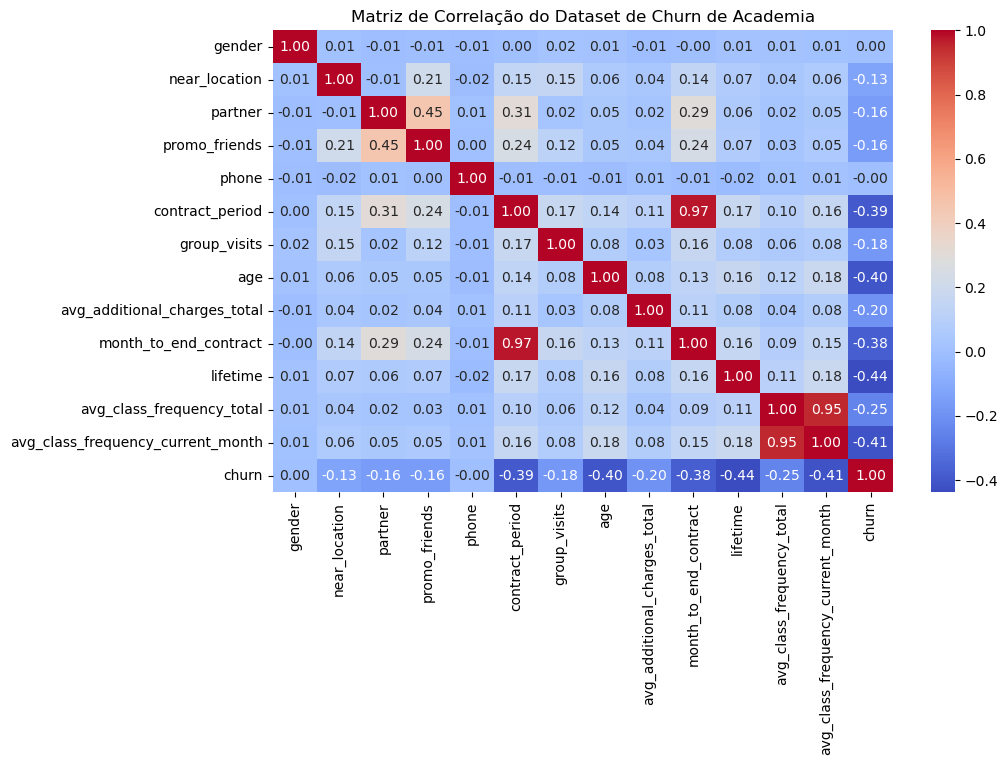

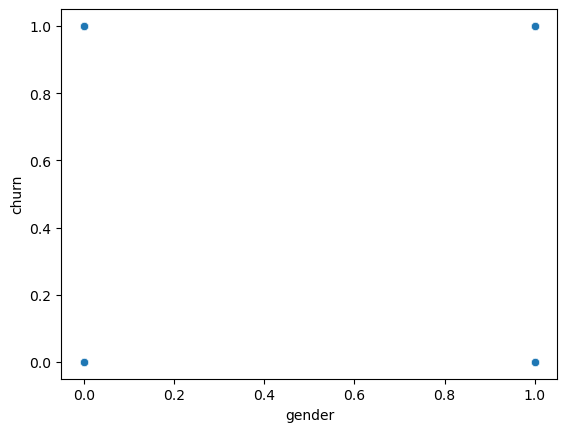

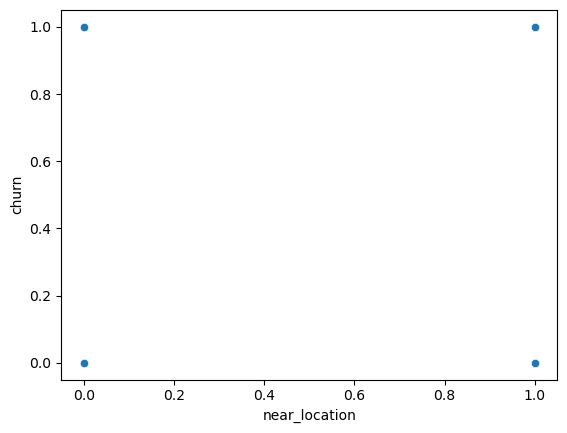

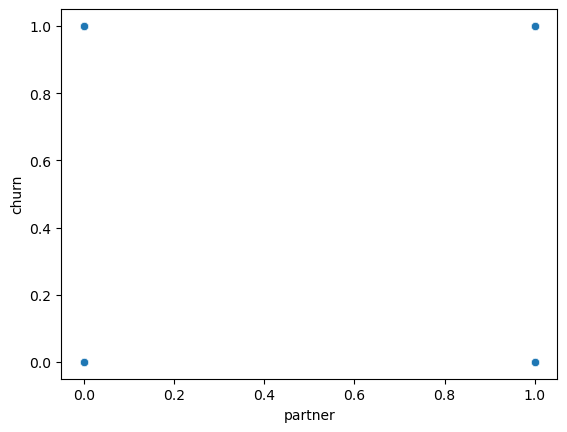

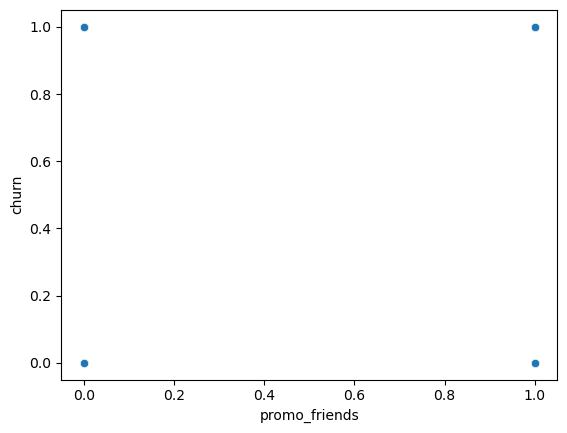

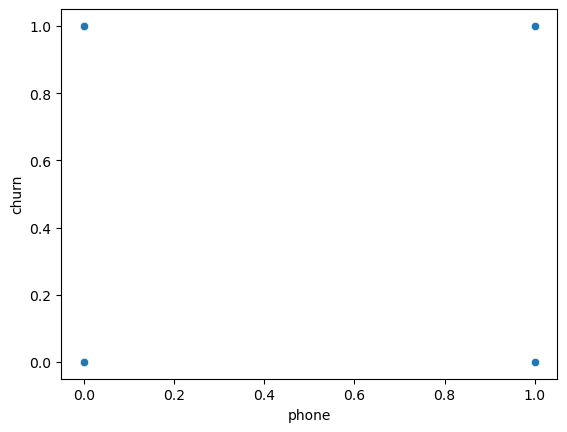

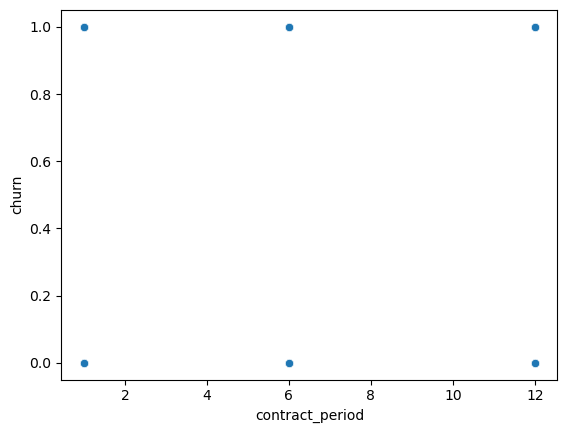

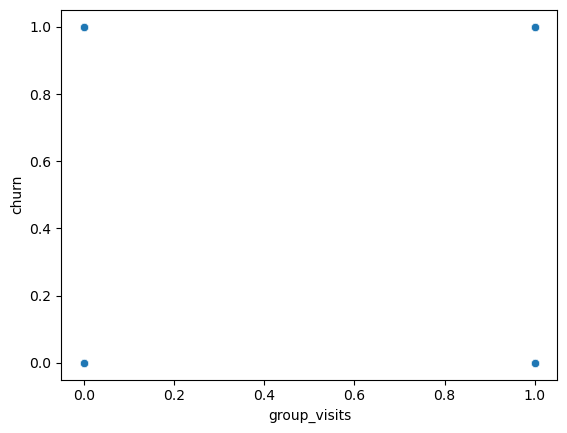

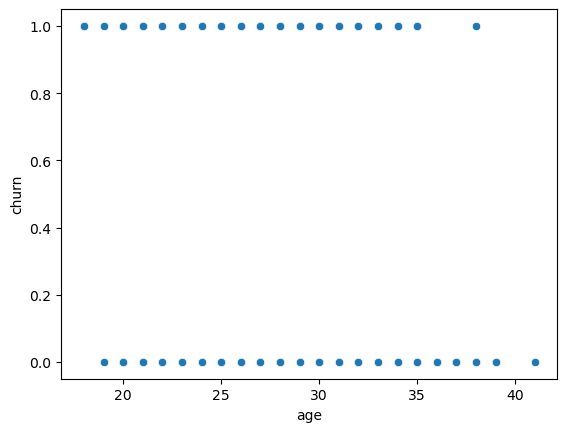

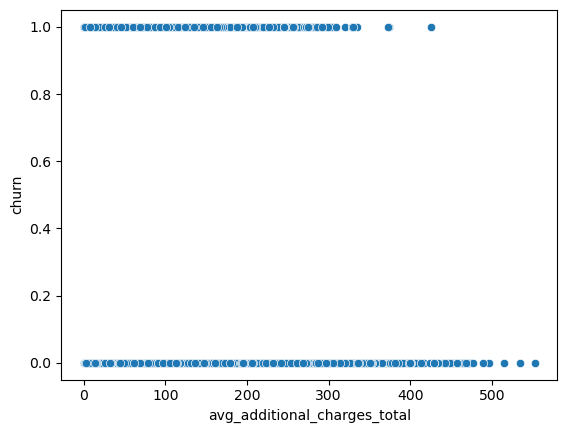

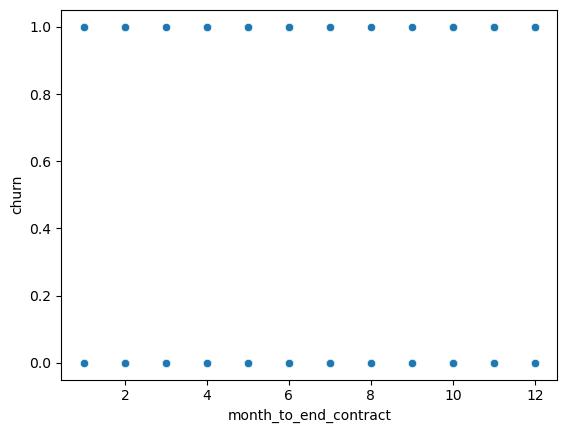

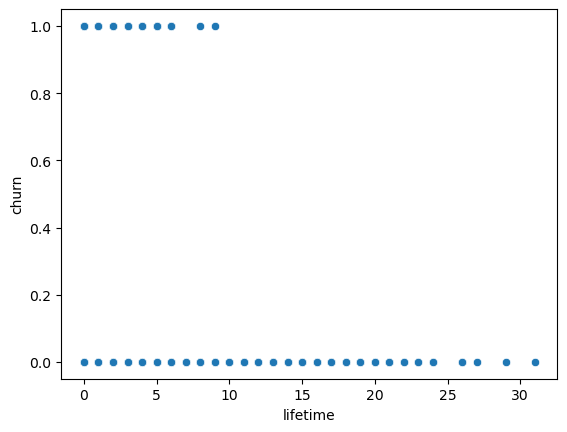

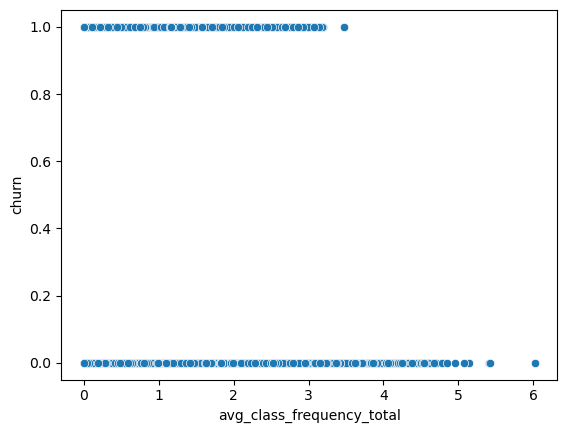

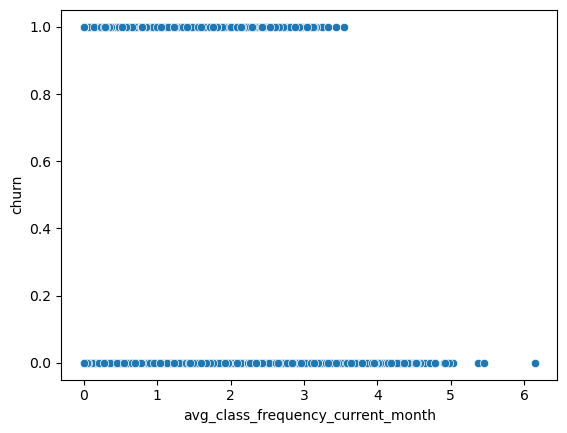

In [57]:
# faça um mapa de calor anotado para a matriz de correlação
corr_fb = fb.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_fb, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação do Dataset de Churn de Academia')
plt.show()


for col in fb.drop('churn', axis=1).columns:
    sns.scatterplot(data=fb, x=col, y='churn')
    plt.show()

## Construa um modelo para predizer a rotatividade de clientes

### Construa um modelo de classificação binária para clientes onde a variável objetivo é a saída de usuários do próximo mês
    - Divida os dados de treinamento e validação em dois conjuntos usando a função train_test_split().

In [58]:
#Dividindo os dados em características (X) e variável goal (y)
X = fb.drop('churn', axis=1)
y = fb['churn']
#Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



### Treine o modelo no conjunto com dois métodos:
  - regressão logística
  - floresta aleatória

In [59]:
# definindo uma funçaõ
def print_all_metrics(y_true, y_pred, y_proba, title = 'Métricas de classificação'):
    print(title)
    print('\tAcurácia: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecisão: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tSensibilidade: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [60]:
#Regressão Logística 
# treine StandardScaler no conjunto de trem
scaler = StandardScaler()
scaler.fit(X_train)

# transforme os conjuntos de trem e teste
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# defina o algoritmo para o modelo de regressão logística
lr_model = LogisticRegression(random_state=0)
# treine o modelo
lr_model.fit(X_train_st, y_train)
# use o modelo treinado para fazer previsões
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# imprima todas as métricas
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Métricas para regressão logística:')

Métricas para regressão logística:
	Acurácia: 0.92
	Precisão: 0.85
	Sensibilidade: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [61]:
# Floresta Aleatória
# define o algoritmo para o novo modelo de floresta aleatória
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# treine o modelo de floresta aleatória
rf_model.fit(X_train_st, y_train)
# use o modelo treinado para fazer previsões
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
# imprima todas as métricas
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Métricas para floresta aleatória:')

Métricas para floresta aleatória:
	Acurácia: 0.92
	Precisão: 0.84
	Sensibilidade: 0.81
	F1: 0.83
	ROC_AUC: 0.97


### Avalie acurácia, precisão e sensibilidade para ambos os modelos usando dados de validação. Use-os para comparar os modelos. Qual modelo rendeu melhores resultados?

# 3. Crie agrupamentode clientes 

- Padronize os dados.
- Use a função linkage() para construir a matriz das distâncias baseada na matriz de características padronizada e construa um dendrograma. Perceba: renderizar o dendrograma pode demorar um tempo! Use o gráfico resultante para estimar o número de agrupamentos que você pode destacar.

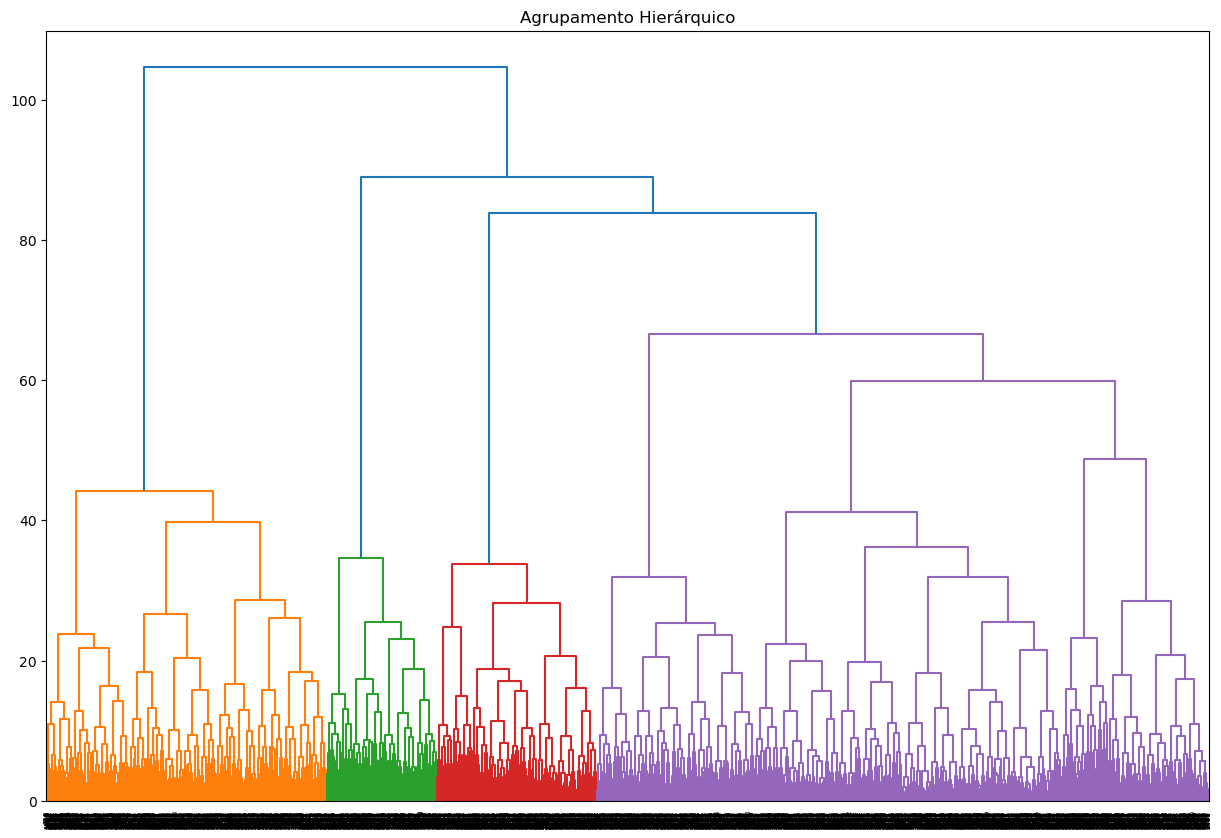

In [67]:
#padronizando os dados
fb_scaled = scaler.fit_transform(X)

linked = linkage(fb_scaled, method='ward')

#plotando 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico')
plt.show()

Treine o modelo de agrupamento com o algoritmo K-means e preveja agrupamentos de clientes. (Deixe que o número de agrupamentos seja n=5,para que seja fácil comparar seus resultados com os de outros estudantes. No entanto, na vida real, ninguém vai te dar essas dicas, para que você tenha que decidir baseados nos gráficos das etapas anteriores.)

In [83]:
# defina o modelo k_means com 3 agrupamentos
km = KMeans(n_clusters=5)
# preveja os agrupamentos para observações (o algoritmo atribui a eles um número de 0 a 4)
labels = km.fit_predict(fb_scaled)

# armazene rótulos de agrupamento no campo do nosso conjunto de dados
fb['cluster_km'] = labels

a = fb.groupby('cluster_km')['churn'].mean()

# calcule a pontuação de silhueta para o agrupamento
print('Silhouette_score: {:.2f}'.format(silhouette_score(fb_scaled, labels)))
display(a)

Silhouette_score: 0.12


cluster_km
0    0.089011
1    0.017570
2    0.054602
3    0.569065
4    0.439856
Name: churn, dtype: float64

# 4. Conclusão 
**Principais Conclusões da Análise**  
A partir da análise exploratória e da modelagem, identificamos fatores determinantes para a permanência do cliente:
- Contratos Longos: Clientes com planos de 6 a 12 meses apresentam uma taxa de churn significativamente menor do que aqueles com planos mensais.
- Proximidade Física: Clientes que moram ou trabalham perto da academia tendem a frequentá-la com mais regularidade e por mais tempo.
= Frequência Semanal: Uma queda na frequência média para menos de 2 vezes por semana no último mês é o principal sinal de alerta de que o cliente está prestes a sair.

**Perfis dos Grupos (Clusters)**  
Através da clusterização, dividimos os clientes em grupos distintos. Os grupos com maior risco de churn geralmente apresentam:
- Baixa idade média.
- Contratos de apenas 1 mês.
- Baixo gasto em serviços extras (café, massagem, suplementos).
Já os grupos fidelizados possuem estabilidade na frequência e maior tempo de contrato acumulado.

**Recomendações Estratégicas**  
Com base nos dados, sugerimos as seguintes ações para a Model Fitness:
- Incentivo à Transição de Contrato: Criar campanhas de upgrade para clientes de planos mensais (maior risco) migrarem para planos semestrais, oferecendo descontos progressivos ou meses bônus.
- Foco no Engajamento de Novatos: Implementar um programa de "Onboarding" nas primeiras 2 semanas, incentivando a participação em pelo menos uma aula em grupo para criar laços sociais.
- Sistema de Alerta Precoce: Monitorar a frequência semanal. Caso um cliente que costuma ir 3 vezes por semana falte por 7 dias consecutivos, o CRM deve disparar uma oferta personalizada ou um convite para uma aula especial.
- Fortalecimento de Parcerias: Expandir o programa de indicação ("Traga um Amigo") e parcerias corporativas, já que esses clientes entram na academia com uma rede de apoio já estabelecida.